[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/gvarnavi/generative-art-iap/blob/master/01.26-Wednesday/02_strange-attractors-py.ipynb)

# Strange Attractors
"[They're] a little like old Uncle Jake, who is a bit eccentric. You’re not really surprised by what Uncle Jake does, but it’s still difficult to understand why he does what he does. But by calling him eccentric, you feel comfortable with his actions." *~ Symmetry in Chaos, Field and Golubitsky*

---

An attractor is a state toward which a dynamical system tends to evolve, and it can take various forms such as a fixed point or a limit cycle. An attractor is called **strange** if it has a fractal structure, which often arises in chaotic systems. Although a strange attractor is locally unstable, meaning nearby points diverge from one another due to sensitive dependence on initial conditions, it is globally stable in that these points never leave the attractor. These attractive orbits can be quite... attractive!

## Getting started
If working within Google Colaboratory, we need to clone the Github repo to access some supporting files for import.

In [ ]:
!git clone https://github.com/gvarnavi/generative-art-iap.git
%cd generative-art-iap/01.26-Wednesday

## Discrete-time systems

First, let's look at some artistic trajectories that arise in discrete-time chaotic dynamical systems. We start by defining some library imports we will need in this notebook.

In [1]:
import numpy as np
import ipywidgets as widgets
import gc
from numba import njit
from strange_attractors_utils import *
from scipy.integrate import solve_ivp
from IPython.display import HTML
from google.colab import files

One popular example is the family of **De Jong attractors**, which are given by the coupled system of equations:

$$x_{n+1} = \text{sin}(ay_n) - \text{cos}(bx_n)$$

$$y_{n+1} = \text{sin}(cx_n) - \text{cos}(dy_n)$$

Let's write a function ```dejong``` that takes as input the current state as an array of $(x, y)$ coordinates, and a tuple of the model parameters $(a,b,c,d)$, and computes a new state array following the De Jong map.



In [2]:
@njit
def dejong(state, args):
    # unpack system parameters
    a, b, c, d = args
    
    # unpack the state vector
    x, y = state
    
    # map to the new state
    return np.array([np.sin(a*y) - np.cos(b*x),
                     np.sin(c*x) - np.cos(d*y)])

In [3]:
state = np.array([-0.3, 0.2])
args = (-2., -2., -1.2, 2.)
dejong(state, args)

array([-1.21475396, -0.56878676])

To visualize the orbit, we'll make a two-dimensional plot of the attractor that is colored by the number of times each point was visited over the course of many iterations. Because we are only interested in plotting the attracting orbit, we will create a function ```calc_orbit``` to iterate through and discard an initial transient of $2000$ iterations, then output only the subsequent iterations up to a maximum $N$.

In [4]:
@njit
def calc_orbit(out, fmap, s0, args, warmup=2000):
    ''' Iterate the function fmap through a transient of warmup iterations and return an array of the final orbit.
        Inputs:
            out - output array to store final orbit
            fmap - function of the iterative map
            x0 - initial value
            args - additional arguments taken by fmap
            warmup - number of transient iterations
    '''
    # iterate through transient behavior
    s = s0
    for i in range(warmup):
        s = fmap(s, args)
        
    # output long-term behavior
    out[0,:] = fmap(s, args)
    for i in range(len(out)-1):
        out[i+1,:] = fmap(out[i,:], args)

In [5]:
N = int(5e6)
s0 = np.array([-0.3, 0.2])
args = (-2., -2., -1.2, 2.)
out = np.zeros((N, len(s0)))

calc_orbit(out, dejong, s0, args)
print(out[-1,:])

[-0.48271815  0.69380126]


The visited states (coordinates) will generally be continuous numbers, but to form an image colored by visitation density, we'll need to bin the points into discrete image pixels. Thus, we define a function ```bin_data``` to bin the continuous $x$ and $y$ coordinates generated by ```calc_orbit``` into discrete image pixels.

In [6]:
@njit
def bin_data(out, z, n):
    ''' Map a continuous coordinate to a discrete point on a grid of length n.
        Inputs:
            out - output array of pixels
            z - array of coordinate values
            n - length of grid
    '''
    out[:] = (z - z.min())/(z.max() - z.min())*(n-1)

In [7]:
nx, ny = 500, 500
bins = np.empty(out.shape, dtype=np.int64)
bin_data(bins[:,0], out[:,0], nx)
bin_data(bins[:,1], out[:,1], ny)
print(bins[-1,:])

[189 343]


We want to color our pixels based on visitation density. The function ```get_counts``` takes our list of bins and counts the number of occurences of each pixel. Because the counts tend to be very big in some regions, and zero in others, we return the base-2 logarithm of the counts instead of the pure counts. This will also improve the contrast of our final image.

In [8]:
def get_counts(bins):
    ''' Compute number of occurrences of each binned coordinate value.
        Inputs:
            bins - array of visited pixels
        Outputs:
            counts - logarithm of counts
    '''
    inverse, counts = np.unique(bins[:,0] + bins[:,1]*1j, return_counts=True, return_inverse=True)[1:]
    counts = np.log2(1 + counts[inverse])
    return counts

In [9]:
counts = get_counts(bins)
print(counts)

[6.79441587 8.55842071 8.0768156  ... 5.42626475 6.39231742 5.97727992]


Finally, we'll define a function ```make_map``` to populate each image pixel with the corresponding number of counts.

In [10]:
@njit
def make_map(image, bins, counts):
    ''' Populate image pixels with corresponding counts.
        Inputs:
            image - two-dimensional image array
            bins - array of visited pixels
            counts - array of counts for each pixel
    '''
    for i in range(len(bins)):
        image[bins[i,0], bins[i,1]] = counts[i]

In [11]:
image = np.zeros((nx, ny), dtype=np.int64)
make_map(image, bins, counts)
print('min: ', image.min(), 'max: ', image.max(), 'mean: ', image.mean())

min:  0 max:  11 mean:  1.967972


Now let's package all these steps into a function ```make_attractor``` to repurpose many times for various two-dimensional systems.

In [12]:
def make_attractor(image, fmap, s0, args, N, warmup=2000):
    ''' Make an image colored by each point's visitation density.
        Inputs:
            image - output image
            fmap - function of the iterative map
            x0 - initial value
            args - additional arguments taken by fmap
            N -  total number of iterations
            warmup - number of transient iterations
    '''
    # compute orbit
    out = np.zeros((N, len(s0)))
    calc_orbit(out, fmap, s0, args, warmup=warmup)

    # format data to grid
    nx, ny = image.shape
    bins = np.zeros(out.shape, dtype=np.int64)
    bin_data(bins[:,0], out[:,0], nx)
    bin_data(bins[:,1], out[:,1], ny)

    # populate image by visitation density
    counts = get_counts(bins)
    make_map(image, bins, counts)

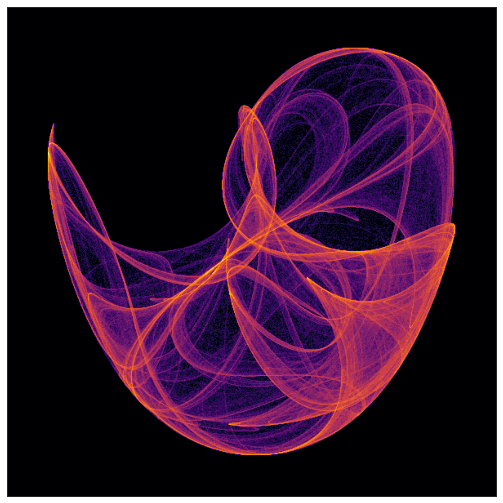

In [13]:
nx, ny = 500, 500
image = np.zeros((nx, ny), dtype=np.int64)

N = int(5e6)
s0 = np.array([-0.3, 0.2])
args = (-2., -2., -1.2, 2.)
make_attractor(image, dejong, s0, args, N)

# display image
f, ax = plot_attractor(image, palette='inferno');

You can change the color palette used for plotting by changing the ```palette``` argument to the name of one of these [colormaps](https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html).

To save an image, you can run a ``f.savefig`` command like the following, where ```f``` is the handle to the figure object, i.e. ```f, ax = plot_attractor(image)```. It will be saved in the same directory as this notebook and should appear in the Jupyter navigation window, where you can select it and download it. If working within Google Colaboratory, you can also use the second line to download the saved image.

In [ ]:
f.savefig('my_figure.png', dpi=400)
files.download('my_figure.png')

You can test some suggested parameters using the widget below.

In [ ]:
nx, ny = 500, 500
N = int(5e6)
s0 = np.array([-0.3, 0.2])

@widgets.interact_manual(args = ['leaf','whale','cocoon','ribbon','crescent','squid','heart'])
def dejong_dropdown(args='leaf'):
    # suggested parameter sets
    leaf = (-2., -2., -1.2, 2.)
    whale = (2.01, -2.53, 1.61, -0.33)
    cocoon = (-2.850, 2.793, -2.697, 1.128)
    ribbon = (1.5, 2.5, 0.731, 2.5)
    crescent = (1.549, 1.104, 2.4, -2.1)
    squid = (-1.33, -2., -1.2, 2.)
    heart = (2.03, -2., -1.2, 2.)
    
    image = np.zeros((nx, ny), dtype=np.int64)
    make_attractor(image, dejong, s0, eval(args), N)
    plot_attractor(image, palette='inferno')
    gc.collect()

Try discovering your own parameters for a unique piece of abstract art. Remember that different parameter windows can produce strikingly different limiting behaviors, so try tuning one parameter at a time to avoid running into too many seemingly blank images! If you get stuck, you can always re-run the cell to reset the defaults, or copy the values of a suggested parameter set above and proceed from there.

In [ ]:
nx, ny = 500, 500
N = int(5e6)
s0 = np.array([-0.3, 0.2])

a_slider = widgets.FloatSlider(value=-2., min=-3., max=3., step=0.01, description='a:', readout_format='.2f')
b_slider = widgets.FloatSlider(value=-2., min=-3., max=3., step=0.01, description='b:', readout_format='.2f')
c_slider = widgets.FloatSlider(value=-1.2, min=-3., max=3., step=0.01, description='c:', readout_format='.2f')
d_slider = widgets.FloatSlider(value=2., min=-3., max=3., step=0.01, description='d:', readout_format='.2f')

@widgets.interact_manual(a = a_slider, b = b_slider, c = c_slider, d = d_slider)
def dejong_slider(a=-2., b=-2., c=-1.2, d=2.):
    image = np.zeros((nx, ny), dtype=np.int64)
    make_attractor(image, dejong, s0, (a,b,c,d), N)
    plot_attractor(image, palette='inferno')
    gc.collect()

Another interesting example is the family of **Clifford attractors**, which are given by the coupled system of equations:

$$x_{n+1} = \text{sin}(ay_n) - c\text{cos}(ax_n)$$

$$y_{n+1} = \text{sin}(bx_n) - d\text{cos}(by_n)$$

Let's write a function ```clifford``` to compute the new state array following the Clifford map.

In [14]:
@njit
def clifford(state, args):
    # unpack system parameters
    a, b, c, d = args
    
    # unpack the state vector
    x, y = state
    
    # map to the new state
    return np.array([np.sin(a*y) - c*np.cos(a*x),
                     np.sin(b*x) - d*np.cos(b*y)])

Now let's plot as before using our visualization code!

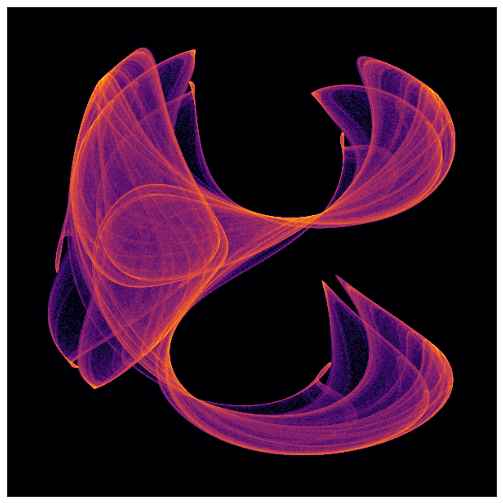

In [15]:
nx, ny = 500, 500
image = np.zeros((nx, ny), dtype=np.int64)

N = int(5e6)
s0 = np.array([-0.3, 0.2])
args = (-1.4, 1.6, 1., 0.7)
make_attractor(image, clifford, s0, args, N)

# display image
f, ax = plot_attractor(image, palette='inferno');

Test some of the suggested parameters using the widget below.

In [ ]:
nx, ny = 500, 500
N = int(5e6)
s0 = np.array([-0.3, 0.2])

@widgets.interact_manual(args = ['arcs','shell','roll','squiggle'])
def clifford_dropdown(args='leaf'):
    # suggested parameter sets
    arcs = (-1.4, 1.6, 1., 0.7)
    shell = (1.7, 1.7, 0.6, 1.2)
    roll = (1.5, -1.8, 1.6, 0.9)
    squiggle = (-1.8, -2.0, -0.5, -0.9)

    image = np.zeros((nx, ny), dtype=np.int64)
    make_attractor(image, clifford, s0, eval(args), N)
    plot_attractor(image, palette='inferno')
    gc.collect()

Play around with the sliders to try and find some other abstract designs.

In [ ]:
nx, ny = 500, 500
N = int(5e6)
s0 = np.array([-0.3, 0.2])

a_slider = widgets.FloatSlider(value=-1.4, min=-2., max=2., step=0.01, description='a:', readout_format='.2f')
b_slider = widgets.FloatSlider(value=1.6, min=-2., max=2., step=0.01, description='b:', readout_format='.2f')
c_slider = widgets.FloatSlider(value=1., min=-2., max=2., step=0.01, description='c:', readout_format='.2f')
d_slider = widgets.FloatSlider(value=0.7, min=-2., max=2., step=0.01, description='d:', readout_format='.2f')

@widgets.interact_manual(a = a_slider, b = b_slider, c = c_slider, d = d_slider)
def clifford_slider(a=-1.4, b=1.6, c=1., d=0.7):
    image = np.zeros((nx, ny), dtype=np.int64)
    make_attractor(image, clifford, s0, (a,b,c,d), N)
    plot_attractor(image, palette='inferno')
    gc.collect()

### Symmetry

*Adapted from Shaw, William T. Complex Analysis with Mathematica. Cambridge University Press, 2006.*

Extraordinary patterns can arise when chaotic systems are constructed to obey some underlying symmetry. The simplest examples are complex polynomial maps that are symmetric under the actions of the **cyclic group** $Z_n$ of rotations by $2 \pi/n$, or the **dihedral group** $D_n$, consisting of rotations by $2 \pi/n$ and a reflection. Note that this $n$ is different from the $n$ we have been using to denote our iteration steps, so we will let $k$ denote our iteration steps to avoid confusion!

The general functional form of such maps is given by:

$$z_{k+1} = f(z_k) = z_k(a + bz_k\bar{z_k} + c\text{Re}(z_k^n) +i\omega) + d\bar{z_k}^{n-1}$$

where $a,b,c,d$, and $\omega$ are real, and $n$ is an integer. These are cyclically symmetric and inherit dihedral symmetry when $\omega = 0$.

Below, we implement a slight variant of this form which we term the nonlinear map:

$$f_\text{nonlinear}(z_k) = z_k(a + bz_k\bar{z_k} + c\text{Re}(z_k^n) + \lambda |z_k| \text{cos}(\text{arg}(z_k)np) +i\omega) + d\bar{z_k}^{n-1}$$

where arg denotes the argument (angle) of a complex number, and where $a,b,c,d,\lambda, \omega$ are real, and $n$ and $p$ are integers.

In [16]:
@njit
def nonlinear(state, args):
    # unpack system parameters
    a, b, c, d, l, w, n, p = args

    # unpack the state vector
    x, y = state
    z = complex(x, y)
    
    # map to the new state
    F = (a + b*z*np.conj(z) + c*(z**n).real + l*np.abs(z)*np.cos(np.angle(z)*n*p) + w*1j)*z + d*np.conj(z)**(n-1)
    return np.array([F.real, F.imag])

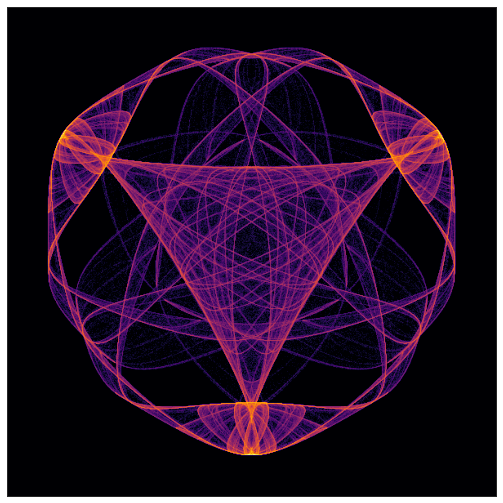

In [17]:
nx, ny = 500, 500
image = np.zeros((nx, ny), dtype=np.int64)

N = int(5e6)
s0 = np.array([-0.3, 0.2])
args = (1.56, -1., 0.1, -0.82, 0., 0., 3, 1)
make_attractor(image, nonlinear, s0, args, N)

# display image
f, ax = plot_attractor(image, palette='inferno');

Try out some of the suggested parameter sets for the different symmetries.

In [ ]:
nx, ny = 500, 500
N = int(5e6)
s0 = np.array([-0.3, 0.2])

@widgets.interact_manual(args = ['threegadget','triangle','quadgig','flint','pentagon','star','sanddollar',
                                 'flower','hexagon','heptagon','churwin','swirlygig','bloom'])
def nonlinear_dropdown(args='sanddollar'):
    # dihedral symmetry parameter sets
    threegadget = (1.56, -1., 0.1, -0.82, 0., 0., 3, 1)
    triangle = (1.455, -1.0, 0.03, -0.8, -0.025, 0., 3, 0)
    quadgig = (-1.86, 2., 0., 1., 0., 0., 4, 0)
    flint = (2.5, -2.5, 0., 0.9, 0., 0., 3, 1)
    pentagon = (2.6, -2., 0., -0.5, 0., 0., 5, 1)
    star = (-2.32, 2.32, 0., 0.75, 0., 0., 5, 1)
    sanddollar = (-2.34, 2., 0.2, 0.1, 0., 0., 5, 1)
    flower = (-2.38, 10.0, -12.3, 0.75, 0.02, 0., 5, 1)
    hexagon = (-2.7, 5., 1.5, 1., 0., 0., 6, 1)
    heptagon = (-2.08, 1.0, -0.1, 0.167, 0., 0., 7, 1)
    churwin = (2.409, -2.5, -0.2, 0.81, 0., 0., 24, 1)

    # cyclical symmetry parameter sets
    swirlygig = (-1.86, 2., 0., 1., 0., 0.1, 4, 0)
    bloom = (-2.5, 5., -1.9, 1., 0., 0.188, 5, 0)

    image = np.zeros((nx, ny), dtype=np.int64)
    make_attractor(image, nonlinear, s0, eval(args), N)
    plot_attractor(image, palette='inferno')
    gc.collect()

Another interesting family of symmetric maps may be constructed with periodic functions like sinusoids. Below, we implement one variant:

$$x_{n+1} = mx_n + a\text{sin}(2 \pi x_n) + b\text{sin}(2 \pi x_n)\text{cos}(2 \pi y_n) + c \text{sin}(4 \pi x_n) + d \text{sin}(6 \pi x_n) \text{cos}(4 \pi y_n)$$

$$y_{n+1} = my_n + a\text{sin}(2 \pi y_n) + b\text{cos}(2 \pi x_n)\text{sin}(2 \pi y_n) + c \text{sin}(4 \pi y_n) + d \text{cos}(4 \pi x_n) \text{sin}(6 \pi y_n)$$

In [18]:
@njit
def periodic(state, args):
    # unpack system parameters
    a, b, c, d, m = args

    # unpack the state vector
    x, y = state
    
    # map to the new state
    return np.array([m*x + a*np.sin(2.*np.pi*x) + b*np.sin(2.*np.pi*x)*np.cos(2.*np.pi*y)
                     + c*np.sin(4.*np.pi*x) + d*np.sin(6.*np.pi*x)*np.cos(4.*np.pi*y),
                     m*y + a*np.sin(2.*np.pi*y) + b*np.cos(2.*np.pi*x)*np.sin(2.*np.pi*y)
                     + c*np.sin(4.*np.pi*y) + d*np.cos(4.*np.pi*x)*np.sin(6.*np.pi*y)])

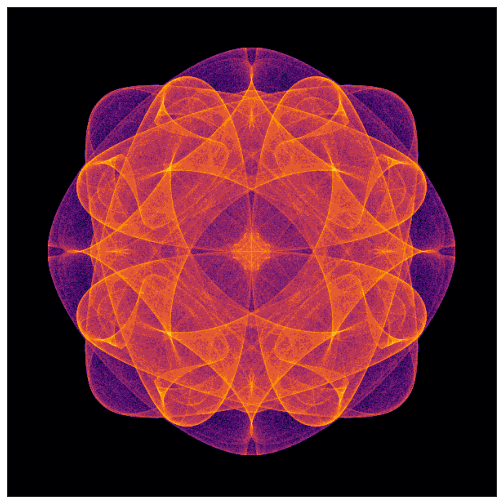

In [19]:
nx, ny = 500, 500
image = np.zeros((nx, ny), dtype=np.int64)

N = int(5e6)
s0 = np.array([-0.3, 0.2])
args = (0.25, -0.3, 0.1, 0.3, 1.)
make_attractor(image, periodic, s0, args, N)

# display image
f, ax = plot_attractor(image, palette='inferno');

We can take advantage of the built-in periodicity to produce beautiful tiled patterns. The function ```plot_attractor_quilt``` simply tiles the calculated image a specified number of repetitions before plotting.

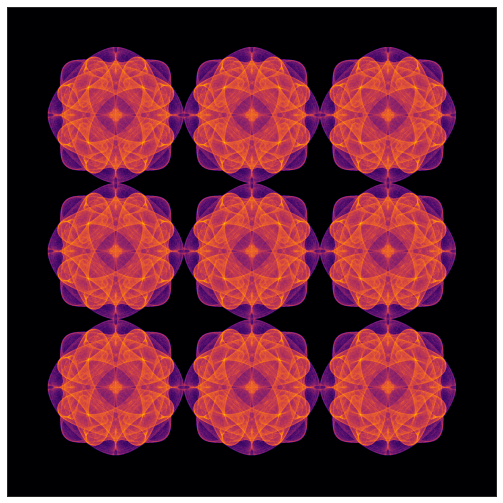

In [20]:
f, ax = plot_attractor_quilt(image, palette='inferno', tile=3);

Explore some other parameters!

In [ ]:
nx, ny = 500, 500
N = int(5e6)
s0 = np.array([-0.3, 0.2])

@widgets.interact_manual(args = ['clover','flower','plus','plus2','plate','cross'], tile = [2,3,4])
def periodic_dropdown(args='clover', tile=3):
    # suggested parameter sets
    clover = (0.25, -0.3, 0.2, 0.3, 1.)
    flower = (0.25, -0.3, 0.1, 0.3, 1.)
    plus = (0.2, -0.2, 0.2, 0.3, 1.)
    plus2 = (0.2, -0.25, 0.2, 0.3, 1.)
    plate = (0.2, -0.2, 0., 0.3, 1.)
    cross = (0.2, -0.2, 0., 0.3, 0.)

    image = np.zeros((nx, ny), dtype=np.int64)
    make_attractor(image, periodic, s0, eval(args), N)
    plot_attractor_quilt(image, palette='inferno', tile=tile)
    gc.collect()

## Continuous-time systems

Chaotic dynamical systems parameterized by continuous time can also generate interesting orbits! And because chaotic systems are characterized by a sensitive dependence on intital conditions, the possible trajectories can diverge rapidly even when the starting conditions differ only slightly. To investigate these properties, we will look at the evolution of some famous three-dimensional chaotic systems over time.

One very well known chaotic attractor is the **Lorenz attractor**, which arises from the evolution of the differential equations:

$$\begin{aligned}
x' &= a(y - x) \\
y' &= x(b - z) - y \\
z' &= xy - cz
\end{aligned}$$

We will implement a function ```lorenz``` to evaluate these equations.

In [21]:
@njit
def lorenz(t, state, args):
    # unpack system parameters
    a, b, c = args
    
    # unpack the state vector
    x, y, z = state
    
    # evaluate system of differential equations at new state
    return np.array([a*(y - x),
                     x*(b - z) - y,
                     x*y - c*z])

In [22]:
t = 0
s0 = np.array([1.,1.,1.])
args = (10., 28., 8./3.)
dsdt = lorenz(t, s0, args)
print(dsdt)

[ 0.         26.         -1.66666667]


Note that in contrast to discrete systems, we now have a function that gives us not the next state, but the local time derivative that tells us how to evolve the system. To solve the differential equations, we will use the function ```solve_ivp``` from the ```scipy``` library. Let's define a function ```calc_trajectory``` to format our input conditions and output a list of three arrays $x, y, z$ of the system's trajectory.

In [23]:
def calc_trajectory(fode, s0, args, times):
    ''' Solve an ordinary differential equation over a specified time.
        Inputs:
            fode - function of the ordinary differential equation to solve
            s0 - initial condition
            args - additional arguments taken by fode
            times -  array of time points at which to solve
        Outputs:
            out - solution to the ode at the specified time points
    '''
    # solve using scipy solver
    out = solve_ivp(lambda t, s: fode(t, s, args), (times[0], times[-1]), s0, t_eval=times).y
    return out

Now, let's calculate and plot the trajectory in three dimensions.

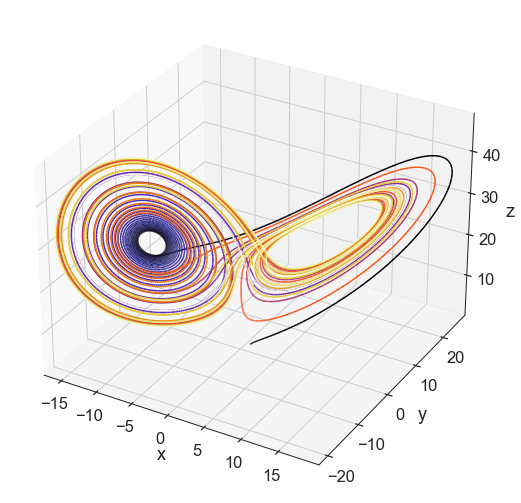

In [24]:
s0 = np.array([1.,1.,1.])
args = (10., 28., 8./3.)
times = np.linspace(0., 50., int(1e4))
out = calc_trajectory(lorenz, s0, args, times)

# plot trajectory
f, ax = plot_trajectory(out, palette='CMRmap')

Let's implement another famous example, the **Rossler attractor**. The Rossler system is given by:

$$\begin{aligned}
x' &= -y - z \\
y' &= x + ay \\
z' &= b + z(x - c)
\end{aligned}$$

In [25]:
@njit
def rossler(t, state, args):
    # unpack system parameters
    a, b, c = args
    
    # unpack the state vector
    x, y, z = state
    
    # evaluate system of differential equations at new state
    return np.array([-y - z,
                     x + a*y,
                     b + z*(x - c)])

We can test it out by updating our earlier code with the Rossler attractor parameters and changing the system name.

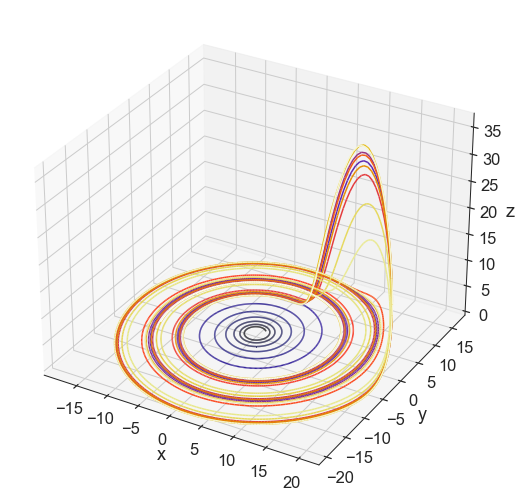

In [26]:
s0 = np.array([1.,1.,0.])
args = (0.1, 0.1, 14.)
times = np.linspace(0., 200., int(1e4))
out = calc_trajectory(rossler, s0, args, times)

# plot trajectory
f, ax = plot_trajectory(out, palette='CMRmap')

### Sensitive dependence on initial conditions

Let's make an animation that reveals how the system evolves given slightly different initial conditions. The animation code used below was adapted from [this blog](https://jakevdp.github.io/blog/2013/02/16/animating-the-lorentz-system-in-3d/), which includes a number of other physics-inspired Python coding challenges you may want to try!

In [ ]:
L = 12                                        # a random starting point will be generated on [-L,L]
N_paths = 20                                  # number of different initial conditions to test
s0 = 2*L*np.random.random((N_paths, 3)) - L   # array of initial conditions
args = (10., 28., 8./3.)
times = np.linspace(0., 4., 500)

out = [[]]*N_paths
for i, s in enumerate(s0):
    out[i] = calc_trajectory(lorenz, s0[i], args, times)

In [ ]:
ani = animate_trajectory(out, palette='rainbow')
HTML(ani.to_html5_video())